In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.interpolate import CubicSpline
from copy import deepcopy

In [3]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

In [4]:
from probability.distributions import HistogramDistribution
from probability.transforms import histogram_transform
from probability.visualization import plot_pdf_transform, plot_pdf_values

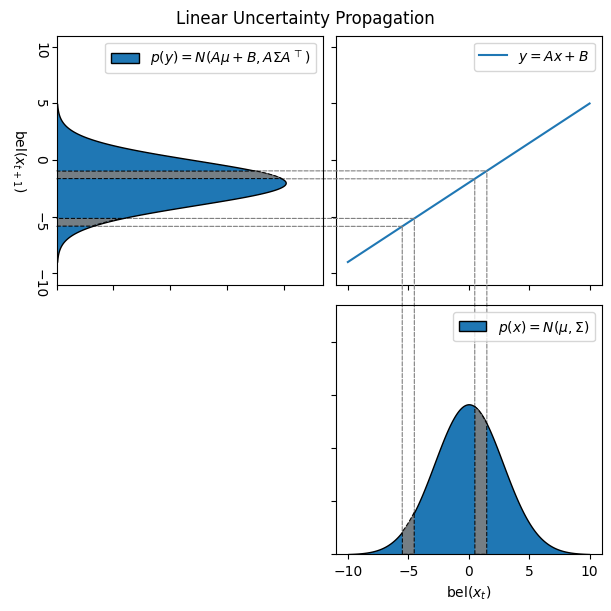

In [5]:
# Linear Belief Propogation Example

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint
prior.pmf_values /= np.sum(prior.pmf_values)

# define the non-linear transform
func = lambda x: 0.7 * x - 2.0

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
axes = plot_pdf_transform(
    prior, transform_values, posterior,
    slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    title="Linear Uncertainty Propagation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"$p(y) = N(A\mu + B, A \Sigma A^\top)$",
    transform_label=r"$y = Ax + B$",
    highlight_color="tab:gray",
    figsize=(6, 6)
)

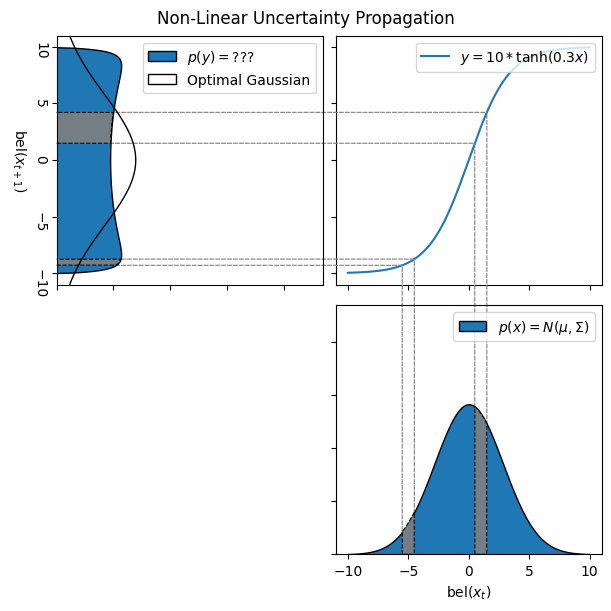

In [6]:
# Non-Linear Belief Propogation Example

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint
prior.pmf_values /= np.sum(prior.pmf_values)

# define the non-linear transform
func = lambda x: 10 * np.tanh(0.3 * x)

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
axes_other = plot_pdf_transform(
    prior, transform_values, posterior,
    slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    title="Non-Linear Uncertainty Propagation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"$p(y) = ???$",
    transform_label=r"$y = 10 * \tanh(0.3x)$",
    highlight_color="tab:gray",
    figsize=(6, 6)
)
axes_other[0, 0].set_xlim(axes[0, 0].get_xlim())
axes_other[1, 1].set_ylim(axes[1, 1].get_ylim())

for ax in axes_other.ravel(): ax.autoscale(enable=False)  # freeze axis limits


# Best fitting Gaussian
posterior_best_fit = HistogramDistribution([(-15, 15)], [1000], None)
posterior_best_fit.pmf_values = multivariate_normal.pdf(posterior_best_fit.bin_midpoints, posterior.get_mean(), posterior.get_covariance())
posterior_best_fit.pmf_values /= np.sum(posterior_best_fit.pmf_values)

plot_pdf_values(
    axes_other[0, 0], posterior_best_fit.bin_midpoints[:,0], posterior_best_fit.pdf_values,
    transpose_axis=True, zorder=300,
    label="Optimal Gaussian",
    # facecolor="tab:purple", alpha=0.6,
    facecolor="none", edgecolor="black", linewidth=1.0
)

axes_other[0, 0].legend(loc="upper right")

(-14.0, 14.0)

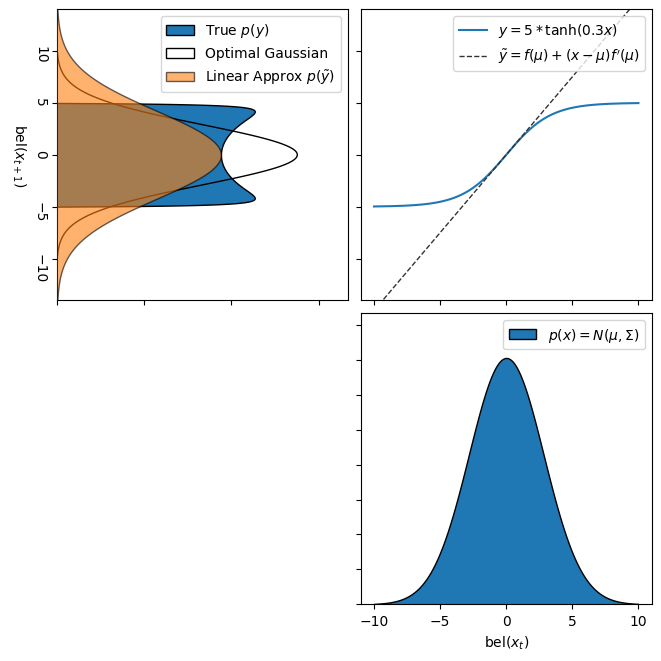

In [13]:
# Non-Linear Belief Propogation - With Linearization

from example_systems import random_smooth_function
import jax
from jax import numpy as jnp

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint
prior.pmf_values /= np.sum(prior.pmf_values)

# define the non-linear transform
# func = lambda x: x + 10 * 1/x * np.sin((0.3*x)**2)
# func = lambda x: x + np.exp(-(0.8*x)**2) * -2*x
# func = lambda x: 5*np.arctan(x)
# func = random_smooth_function([(-10, 10)], [(-10, 10)])
# func = lambda x: 0.01 * x**3 + 0.3*x
func = lambda x: 5 * jnp.tanh(0.3 * x)

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
axes = plot_pdf_transform(
    prior, transform_values, posterior,
    # slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    # title="Non-Linear Uncertainty Propagation\nvia Linear Approximation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"True $p(y)$",
    transform_label=r"$y = 5 * \tanh(0.3x)$",
    figsize=(6.5, 6.5),
)


# Best fitting Gaussian
posterior_best_fit = HistogramDistribution([(-15, 15)], [1000], None)
posterior_best_fit.pmf_values = multivariate_normal.pdf(posterior_best_fit.bin_midpoints, posterior.get_mean(), posterior.get_covariance())
posterior_best_fit.pmf_values /= np.sum(posterior_best_fit.pmf_values)


plot_pdf_values(
    axes[0, 0], posterior_best_fit.bin_midpoints[:,0], posterior_best_fit.pdf_values,
    transpose_axis=True, zorder=300,
    label="Optimal Gaussian",
    # facecolor="tab:purple", alpha=0.6,
    facecolor="none", edgecolor="black", linewidth=1.0
)

# for ax in axes.ravel(): ax.autoscale(enable=False)  # freeze axis limits


# Linear approximation transform (EKF)
slope = jax.jacfwd(func)(0.0)
intercept = func(0)
func_linear_approx = lambda x: intercept + slope * x
func_linear_approx_values = func_linear_approx(prior.domain[:,0])

# compute the approximate posterior
posterior_approx_linear = histogram_transform(func_linear_approx, prior)

axes[0, 1].plot(
    prior.domain[:,0], func_linear_approx_values,
    color="#333", linewidth=1.0,
    linestyle="--", label=r"$\tilde{y} = f(\mu) + (x-\mu)f'(\mu)$"
)

plot_pdf_values(
    axes[0, 0], posterior_approx_linear.bin_midpoints[:,0], posterior_approx_linear.pdf_values,
    transpose_axis=True, zorder=300,
    # label=r"$p(\tilde{y}) = N(f(\mu), f'(\mu) \Sigma f'(\mu)^\top)$"
    label=r"Linear Approx $p(\tilde{y})$",
    facecolor="tab:orange", alpha=0.6,
    # facecolor="none", edgecolor="tab:orange", linewidth=1.5

)

axes[0, 0].legend(loc="upper right")
axes[0, 1].legend(loc="upper right")

axes[0, 0].set_ylim(-14, 14)        # for consistency

(-14.0, 14.0)

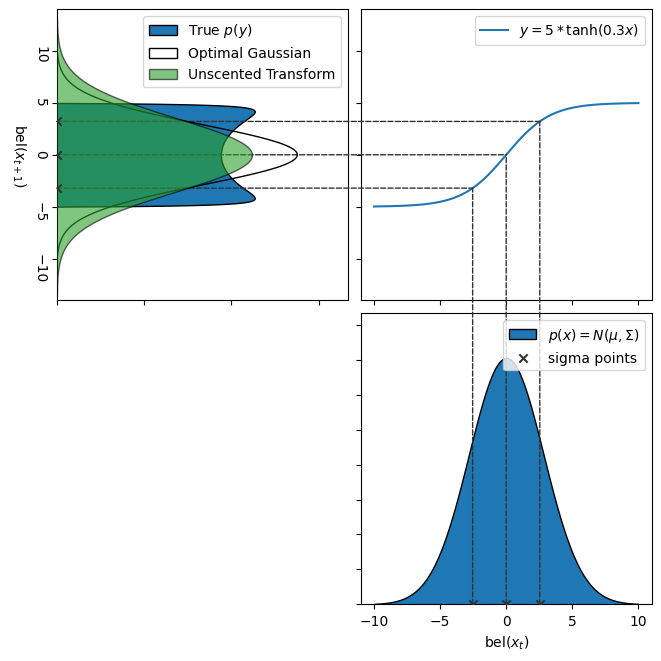

In [17]:
# Non-Linear Belief Propogation - With Unscented Transform

from example_systems import random_smooth_function
import jax
from jax import numpy as jnp

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint
prior.pmf_values /= np.sum(prior.pmf_values)

# define the non-linear transform
# func = lambda x: x + 10 * 1/x * np.sin((0.3*x)**2)
# func = lambda x: x + np.exp(-(0.8*x)**2) * -2*x
# func = lambda x: 5*np.arctan(x)
# func = random_smooth_function([(-10, 10)], [(-10, 10)])
func = lambda x: 5 * jnp.tanh(0.3 * x)

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
axes = plot_pdf_transform(
    prior, transform_values, posterior,
    # slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    # title="Non-Linear Uncertainty Propagation\nvia Unscented Transform",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"True $p(y)$",
    transform_label=r"$y = 5 * \tanh(0.3x)$",
    figsize=(6.5, 6.5),
)


# Best fitting Gaussian
posterior_best_fit = HistogramDistribution([(-15, 15)], [1000], None)
posterior_best_fit.pmf_values = multivariate_normal.pdf(posterior_best_fit.bin_midpoints, posterior.get_mean(), posterior.get_covariance())
posterior_best_fit.pmf_values /= np.sum(posterior_best_fit.pmf_values)


plot_pdf_values(
    axes[0, 0], posterior_best_fit.bin_midpoints[:,0], posterior_best_fit.pdf_values,
    transpose_axis=True, zorder=300,
    label="Optimal Gaussian",
    # facecolor="tab:purple", alpha=0.6,
    facecolor="none", edgecolor="black", linewidth=1.0
)

# for ax in axes.ravel(): ax.autoscale(enable=False)  # freeze axis limits

# Unscented transform (UKF)
from probability.transforms import unscented_transform
from probability.sigma_points import StandardSigmaPointSelector


mean_y, cov_yy, cov_xy, sigma_points, sigma_points_transformed = unscented_transform(
    func, prior.get_mean().reshape(-1,1), prior.get_covariance(),
    StandardSigmaPointSelector(alpha=0.9), return_sigma_points=True
)
sigma_points = sigma_points.flatten()
sigma_points_transformed = sigma_points_transformed.flatten()

posterior_approx_unscented = HistogramDistribution([(-15, 15)], [1000], None)
posterior_approx_unscented.pmf_values = multivariate_normal.pdf(posterior_approx_unscented.bin_midpoints, mean_y, cov_yy)
posterior_approx_unscented.pmf_values /= np.sum(posterior_approx_unscented.pmf_values)

plot_pdf_values(
    axes[0, 0], posterior_approx_unscented.bin_midpoints[:,0], posterior_approx_unscented.pdf_values,
    transpose_axis=True, zorder=300,
    label="Unscented Transform",
    facecolor="tab:green", alpha=0.6,
    # linestyle="--"
    # facecolor="none", edgecolor="tab:green"
)

# plot sigma points
axes[1, 1].scatter(sigma_points, np.zeros_like(sigma_points), marker="x", color="#333", label="sigma points", zorder=999)
axes[0, 0].scatter(np.zeros_like(sigma_points), sigma_points_transformed, marker="x", color="#333", zorder=999)

from matplotlib.patches import ConnectionPatch

for i in range(len(sigma_points)):
    x = sigma_points[i]
    y = sigma_points_transformed[i]
    axes[1,1].add_artist(ConnectionPatch(
        (x, 0), (x, y),
        coordsA="data", coordsB="data",
        axesA=axes[1, 1], axesB=axes[0, 1],
        color="#333", linestyle="--", linewidth=1.0,
        zorder=10
    ))

    axes[0,0].add_artist(ConnectionPatch(
        (0, y), (x, y),
        coordsA="data", coordsB="data",
        axesA=axes[0, 0], axesB=axes[0, 1],
        color="#333", linestyle="--", linewidth=1.0,
        zorder=10
    ))


axes[0, 0].legend(loc="upper right").set_zorder(10_000)
axes[0, 1].legend(loc="upper right").set_zorder(10_000)
axes[1, 1].legend(loc="upper right").set_zorder(10_000)

axes[0, 0].set_ylim(-14, 14)        # for consistency

(-14.0, 14.0)

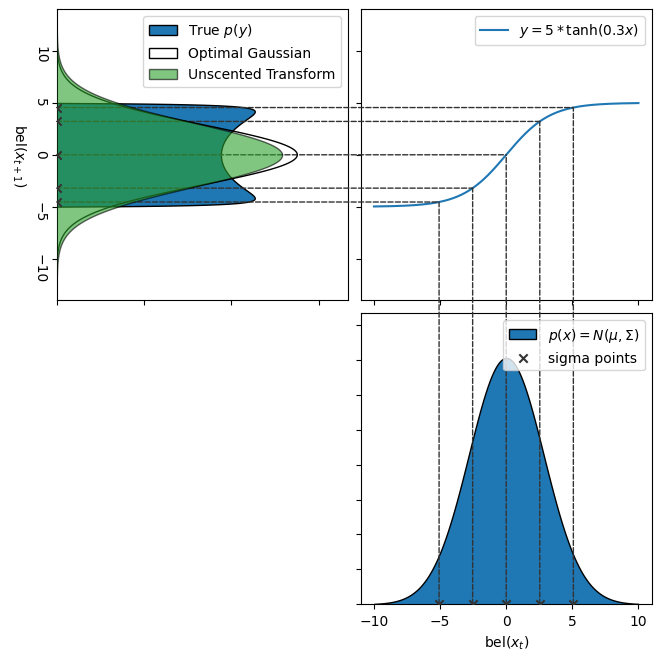

In [15]:
# Non-Linear Belief Propogation - With Unscented Transform

from example_systems import random_smooth_function
import jax
from jax import numpy as jnp

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint
prior.pmf_values /= np.sum(prior.pmf_values)

# define the non-linear transform
# func = lambda x: x + 10 * 1/x * np.sin((0.3*x)**2)
# func = lambda x: x + np.exp(-(0.8*x)**2) * -2*x
# func = lambda x: 5*np.arctan(x)
# func = random_smooth_function([(-10, 10)], [(-10, 10)])
func = lambda x: 5 * jnp.tanh(0.3 * x)

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
axes = plot_pdf_transform(
    prior, transform_values, posterior,
    # slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    # title="Non-Linear Uncertainty Propagation\nvia Modified Unscented Transform",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"True $p(y)$",
    transform_label=r"$y = 5 * \tanh(0.3x)$",
    figsize=(6.5, 6.5),
)


# Best fitting Gaussian
posterior_best_fit = HistogramDistribution([(-15, 15)], [1000], None)
posterior_best_fit.pmf_values = multivariate_normal.pdf(posterior_best_fit.bin_midpoints, posterior.get_mean(), posterior.get_covariance())
posterior_best_fit.pmf_values /= np.sum(posterior_best_fit.pmf_values)


plot_pdf_values(
    axes[0, 0], posterior_best_fit.bin_midpoints[:,0], posterior_best_fit.pdf_values,
    transpose_axis=True, zorder=300,
    label="Optimal Gaussian",
    # facecolor="tab:purple", alpha=0.6,
    facecolor="none", edgecolor="black", linewidth=1.0
)

# for ax in axes.ravel(): ax.autoscale(enable=False)  # freeze axis limits

# Unscented transform (UKF)
from probability.transforms import unscented_transform
from probability.sigma_points import MultiShellSigmaPointSelector


mean_y, cov_yy, cov_xy, sigma_points, sigma_points_transformed = unscented_transform(
    func, prior.get_mean().reshape(-1,1), prior.get_covariance(),
    MultiShellSigmaPointSelector(alphas=[0.9, 1.8]),      # MODIFIED HERE
    return_sigma_points=True
)
sigma_points = sigma_points.flatten()
sigma_points_transformed = sigma_points_transformed.flatten()

posterior_approx_unscented = HistogramDistribution([(-15, 15)], [1000], None)
posterior_approx_unscented.pmf_values = multivariate_normal.pdf(posterior_approx_unscented.bin_midpoints, mean_y, cov_yy)
posterior_approx_unscented.pmf_values /= np.sum(posterior_approx_unscented.pmf_values)

plot_pdf_values(
    axes[0, 0], posterior_approx_unscented.bin_midpoints[:,0], posterior_approx_unscented.pdf_values,
    transpose_axis=True, zorder=300,
    label="Unscented Transform",
    facecolor="tab:green", alpha=0.6,
    # linestyle="--"
    # facecolor="none", edgecolor="tab:green"
)

# plot sigma points
axes[1, 1].scatter(sigma_points, np.zeros_like(sigma_points), marker="x", color="#333", label="sigma points", zorder=999)
axes[0, 0].scatter(np.zeros_like(sigma_points), sigma_points_transformed, marker="x", color="#333", zorder=999)

from matplotlib.patches import ConnectionPatch

for i in range(len(sigma_points)):
    x = sigma_points[i]
    y = sigma_points_transformed[i]
    axes[1,1].add_artist(ConnectionPatch(
        (x, 0), (x, y),
        coordsA="data", coordsB="data",
        axesA=axes[1, 1], axesB=axes[0, 1],
        color="#333", linestyle="--", linewidth=1.0,
        zorder=10
    ))

    axes[0,0].add_artist(ConnectionPatch(
        (0, y), (x, y),
        coordsA="data", coordsB="data",
        axesA=axes[0, 0], axesB=axes[0, 1],
        color="#333", linestyle="--", linewidth=1.0,
        zorder=10
    ))


axes[0, 0].legend(loc="upper right").set_zorder(10_000)
axes[0, 1].legend(loc="upper right").set_zorder(10_000)
axes[1, 1].legend(loc="upper right").set_zorder(10_000)

axes[0, 0].set_ylim(-14, 14)        # for consistency